---
# Machine Learning pour expliquer les variations journalières des prix des contrats à terme d'électricité en France et en Allemagne
---

In [1]:
# Common modules
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Data Preparation
from scipy.stats import pearsonr

# Modelling

# Testing

%matplotlib inline
def display_m(string):
    display(Markdown(string))

# Introduction

---

---

# Compréhension du problème métier

## Qu'est-ce que le prix des contrats a terme d'electricite ?

Le prix des contrats à terme d'électricité est un prix négocié entre un acheteur et un vendeur pour un certain volume d'électricité à une date future spécifiée. Ces contrats permettent à l'acheteur de garantir un prix fixe pour l'électricité à une date future, ce qui lui permet de se protéger contre les fluctuations imprévues des prix du marché de l'électricité. Pour le vendeur, ces contrats lui permettent de garantir un prix fixe pour la vente d'électricité à une date future, ce qui peut lui permettre de planifier ses revenus futurs avec plus de certitude. Les prix des contrats à terme sont souvent basés sur les prix du marché spot de l'électricité, qui fluctuent en fonction de l'offre et de la demande. Les contrats à terme peuvent avoir des échéances différentes, allant de quelques heures à plusieurs années.

## Qui sont les acheteurs et vendeurs des contrats a terme d'electricite ?

Les acheteurs peuvent être des consommateurs d'électricité tels que des entreprises industrielles ou commerciales qui ont besoin d'acheter de grandes quantités d'électricité pour leur activité. Les vendeurs peuvent être des producteurs d'énergie tels que des centrales électriques qui produisent de l'électricité et vendent leur production sur le marché de l'électricité, ou des courtiers en énergie qui achètent et vendent de l'électricité sur les marchés pour réaliser des profits.

---
---

---
Compréhension des données
===

Nous avons trois datasets au format csv:
- **Data_x.csv**: les données d'entrée
- **Data_y.csv**: les données de sorties, c'est-à-dire la variation du prix de futures d'électricités
- **DataNew_x.csv**: les nouvelles données d'entrée non labélisées

Description des données d'entrée 
---

Les datasets d'entrée **Data_x** et **DataNew_x** sont composés de **1494** et **654** entrées respectivement avec **35** variables. 
Nous avons donc **2148** enregistrements au total.

**1. Identifiants :**
  - `ID` : Identifiant unique pour chaque entrée

**2. Variables temporelles :**
- `DAY_ID` : Date de l'entrée sous forme numérique

**3. Variable catégorielle :**
- `COUNTRY` : Pays concerné par l'entrée - DE = Allemagne, FR = France

**4. Variables de consommation et d'échange d'électricité :**
- France:
    - `FR_CONSUMPTION` : Consommation d'électricité en France
    - `FR_DE_EXCHANGE` : Electricité échangée entre France et Allemagne
    - `FR_NET_EXPORT` : Electricité exportée par la France vers l'Europe
    - `FR_NET_IMPORT` : Electricité importée en France depuis l'Europe
- Allemagne:
    - `DE_CONSUMPTION` : Consommation d'électricité en Allemagne
    - `DE_FR_EXCHANGE` : Electricité échangée entre Allemagne et France
    - `DE_NET_EXPORT` : Electricité exportée par l'Allemagne vers l'Europe
    - `DE_NET_IMPORT` : Electricité importée en Allemagne depuis l'Europe

**5. Variables de consommation d'énergie :**
- France:
    - `FR_GAS` : Volume de gaz naturel consommé en France
    - `FR_COAL` : Volume de charbon consommé en France
- Allemagne:
    - `DE_GAS` : Volume de gaz naturel consommé en Allemagne
    - `DE_COAL` : Volume de charbon consommé en Allemagne
    - `DE_LIGNITE` : Volume de lignite consommé en Allemagne

**6. Variables de production d'électricité :**
- France:
    - `FR_HYDRO` : Production d'électricité d'origine hydraulique en France
    - `FR_NUCLEAR` : Production d'électricité d'origine nucléaire en France
    - `FR_SOLAR` : Production d'électricité d'origine photovoltaïque en France
    - `FR_WINDPOW` : Production d'électricité d'origine éolienne en France
- Allemagne:
    - `DE_HYDRO` : Production d'électricité d'origine hydraulique en Allemagne
    - `DE_NUCLEAR` : Production d'électricité d'origine nucléaire en Allemagne
    - `DE_SOLAR` : Production d'électricité d'origine photovoltaïque en Allemagne
    - `DE_WINDPOW` : Production d'électricité d'origine éolienne en Allemagne

**7. Variables de charge résiduelle :**
- France:
    - `FR_RESIDUAL_LOAD` : Electricité consommée après utilisation des énergies renouvelables en France
- Allemagne:
    - `DE_RESIDUAL_LOAD` : Electricité consommée après utilisation des énergies renouvelables en Allemagne

**8. Variables météorologiques :**
- France:
    - `FR_RAIN` : Quantité de pluie tombée en France
    - `FR_WIND` : Vitesse du vent en France
    - `FR_TEMP` : Température en France
- Allemagne:
    * `DE_RAIN` : Quantité de pluie tombée en Allemagne
    * `DE_WIND` : Vitesse du vent en Allemagne
    * `DE_TEMP` : Température en Allemagne

**9. Variables de prix :**
- `GAS_RET` : Prix journalier du gaz naturel en Europe
- `COAL_RET` : Prix journalier du charbon en Europe
- `CARBON_RET` : Prix journalier des émissions de carbone en Europe


Description des données de sortie 
---

Le dataset de sortie **Data_y** est composé de **1494** entrées \
avec **2** variables:
- `ID` : Identifiant unique pour chaque entrée
- `TARGET` : Variation journalière du prix de futures d'électricité (maturité 24h)

---
# Préparation des données

Chargement des donnees initiales
--- 

Nous avons trois datasets au format csv:
- `data_x`: les données d'entrée
- `data_y`: les données de sorties, c'est-à-dire la variation du prix de futures d'électricité pour les enregistrements de `data_x`
- `dataNew_x` : les nouvelles données d'entrée a prédire (de meme format et de meme dimensions que data_x)

In [2]:
# On indexe les dataframes sur la colonne 'ID' (on utilisera donc df.index pour acceder a l'ID)
data_x = pd.read_csv("data/Data_X.csv", index_col='ID')
dataNew_x = pd.read_csv("data/DataNew_X.csv", index_col='ID')
data_y = pd.read_csv("data/Data_Y.csv", index_col='ID')

<br>

Dans la suite de cette partie, nous allons preparer les données de toutes les enregistrements `data_x` et `dataNew_x`.
Pour cela, on obtient le dataframe de tous les enregistrements `all_data_x` a l'aide de la méthode *concat()* de pandas:

In [3]:
all_data_x = pd.concat( [data_x, dataNew_x] , axis=0)

In [4]:
vars_fr = ['FR_CONSUMPTION', 'FR_NET_EXPORT', 'FR_NET_IMPORT', 'FR_GAS', 'FR_COAL', 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW', 'FR_RESIDUAL_LOAD', 'FR_RAIN', 'FR_WIND', 'FR_TEMP']

vars_de = ['DE_CONSUMPTION', 'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_GAS', 'DE_COAL', 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_RESIDUAL_LOAD', 'DE_RAIN', 'DE_WIND', 'DE_TEMP']
t_data_x = data_x.dropna()
fr = t_data_x[vars_fr]
de = t_data_x[vars_de]
res = fr.mean().to_numpy() - de.mean().to_numpy()
res = pd.DataFrame(res)
display(pd.DataFrame(vars_fr).T)
res.T

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,FR_CONSUMPTION,FR_NET_EXPORT,FR_NET_IMPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,FR_RESIDUAL_LOAD,FR_RAIN,FR_WIND,FR_TEMP


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.472452,0.164256,-0.164256,-0.389792,-0.292264,-0.719359,-0.010207,0.403979,0.25368,-0.249738,0.038525,0.011683,0.000998


In [5]:
all_data_x.mean()

C:\Users\coren\AppData\Local\Temp\ipykernel_15664\797889888.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_data_x.mean()


DAY_ID              604.309125
DE_CONSUMPTION        0.429817
FR_CONSUMPTION       -0.003449
DE_FR_EXCHANGE       -0.114830
FR_DE_EXCHANGE        0.114830
DE_NET_EXPORT        -0.245501
FR_NET_EXPORT        -0.088621
DE_NET_IMPORT         0.245501
FR_NET_IMPORT         0.088621
DE_GAS                0.793509
FR_GAS                0.411276
DE_COAL              -0.120853
FR_COAL              -0.436802
DE_HYDRO              0.539091
FR_HYDRO              0.124730
DE_NUCLEAR           -0.493672
FR_NUCLEAR           -0.437675
DE_SOLAR              0.224439
FR_SOLAR              0.600413
DE_WINDPOW            0.144040
FR_WINDPOW            0.363861
DE_LIGNITE           -0.286642
DE_RESIDUAL_LOAD      0.078124
FR_RESIDUAL_LOAD     -0.129632
DE_RAIN              -0.000009
FR_RAIN               0.008455
DE_WIND               0.103704
FR_WIND               0.109674
DE_TEMP              -0.005285
FR_TEMP              -0.009413
GAS_RET               0.060070
COAL_RET              0.072950
CARBON_R

GAS aug
Hydro aug
Solar aug
%%%%
WIND =
%%%%
COAL dim
Nuclear dim beacoup

## Traitement des valeurs aberrantes

Pour la partie sur le traitement des valeurs aberrantes, nous allons utiliser une méthode de détection d'outliers basée sur la standardisation des données. Cette méthode consiste à mesurer la distance entre chaque valeur de notre ensemble de données et la moyenne de l'ensemble, puis à diviser cette distance par l'écart type de l'ensemble. 

En utilisant un seuil défini, nous pouvons détecter les valeurs qui ont un score z supérieur à ce seuil, et considérer ces valeurs comme des outliers potentielles.

La formule de la standardisation est donnée par :

$$ z = \frac{x - \mu}{\sigma} $$

où $x$ est la valeur individuelle, $\mu$ est la moyenne de l'ensemble et $\sigma$ est l'écart type de l'ensemble. Cette formule nous permet de transformer chaque valeur de l'ensemble en un score z, qui nous aide à identifier les outliers.

Nous allons maintenant écrire la fonction `detect_outliers()` qui utilise cette méthode pour détecter les outliers dans notre ensemble de données.

In [6]:
def detect_outliers(all_data_X):
    df = all_data_x.drop(['DAY_ID', 'COUNTRY'], axis=1)
    z_scores = np.abs((df - df.mean()) / df.std())
    outliers_mask = z_scores > 3
    
    return outliers_mask

outliers = detect_outliers(all_data_x)
# all_data_x[outliers].hist()

---

# 3.4 Modélisation des données


Dans cette section, nous allons utiliser différents algorithmes de Machine Learning pour entraîner des modèles de prédiction à partir de nos données. Les modèles suivants seront mis en œuvre :

1. Régression linéaire simple
2. Régression linéaire régularisée (Régression RIDGE / Régression LASSO)
3. Méthode des k plus proches voisins pour la régression (K-NN, k-Nearest Neighbors regressor)
4. Arbres de décision pour la régression (Decision tree regressor)
5. En bonus, les Forêts aléatoires (Random Forest regressor)

Il est important de comprendre les deux variantes de régression linéaire régularisée et de les décrire brièvement dans le rapport. Il en va de même pour la méthode bonus.


In [7]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr



df = data_x.merge(data_y, on='ID')
df = df[ df['COUNTRY'] == 'FR' ].drop(columns=['DAY_ID', 'COUNTRY'])

In [8]:
import matplotlib
params = {'axes.titlesize':'10',
          'xtick.labelsize':'5',
          'ytick.labelsize':'5'}
# matplotlib.rcParams.update(params)

In [9]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)  # to rever

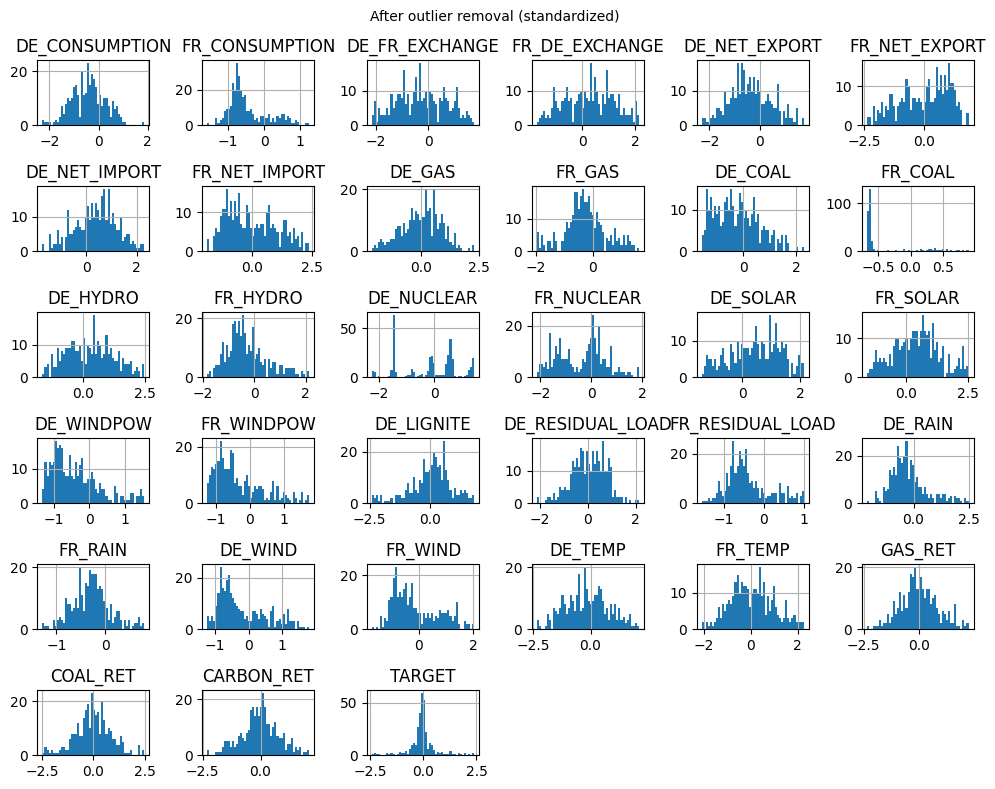

In [10]:
from scipy import stats

# Remove any rows with missing or invalid data
df.dropna(inplace=True)

# Standardize the data
df_std = (df - df.mean()) / df.std()

# Apply Z-score method to each numerical column in the dataframe
for col in df_std.select_dtypes(include=np.number):
    z_scores = stats.zscore(df_std[col])
    abs_z_scores = np.abs(z_scores)
    
    # Set a more conservative threshold for outlier removal
    threshold = 2.5
    
    # Remove any rows with absolute Z-score greater than the threshold
    df_std = df_std[(abs_z_scores < threshold) | df_std[col].isnull()]

# Apply IQR method to any columns with a skewed distribution
for col in df_std.select_dtypes(include=np.number):
    if df_std[col].skew() > 1:
        Q1 = df_std[col].quantile(0.25)
        Q3 = df_std[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        df_std = df_std[(df_std[col] >= lower_bound) & (df_std[col] <= upper_bound)]

# Set hyperparameters for font size of titles and axes
title_fontsize = 10
axes_fontsize = 5

# # Visualize the data before and after outlier removal to ensure effectiveness
# before = df_std.select_dtypes(include=np.number)
# before.hist(bins=50, figsize=(10, 8))
# plt.suptitle("Before outlier removal (standardized)", fontsize=title_fontsize)
# plt.xlabel("Value", fontsize=axes_fontsize)
# plt.ylabel("Frequency", fontsize=axes_fontsize)
# plt.tight_layout()

df_cleaned = df_std.dropna()
after = df_cleaned.select_dtypes(include=np.number)
after.hist(bins=50, figsize=(10, 8))
plt.suptitle("After outlier removal (standardized)", fontsize=title_fontsize)
plt.xlabel("Value", fontsize=axes_fontsize)
plt.ylabel("Frequency", fontsize=axes_fontsize)
plt.tight_layout()
plt.show()
df = df_cleaned

In [11]:
column_to_analyse = ['FR_COAL', 'FR_NUCLEAR', 'FR_HYDRO', 'FR_SOLAR', 'FR_WIND', 'FR_GAS', 'TARGET']
df = df[column_to_analyse]

# Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df.drop('TARGET', axis=1), df['TARGET'], test_size=0.2, random_state=42)

# Define models
models = {
    "linear": LinearRegression(),
    "ridge": Ridge(),
    "lasso": Lasso(),
    "knn": KNeighborsRegressor(),
    "decision_tree": DecisionTreeRegressor(),
    "random_forest": RandomForestRegressor(),
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"Model {name} trained.")

Model linear trained.
Model ridge trained.
Model lasso trained.
Model knn trained.
Model decision_tree trained.
Model random_forest trained.


# 3.5 Évaluation des modèles


Les modèles seront évalués en utilisant des métriques relatives à la régression telles que :

1. la corrélation de Spearman,
2. le coefficient de détermination R2,
3. l'erreur quadratique moyenne (RMSE).

Au cours de cette phase, nous devons :

1. Optimiser chaque modèle : Varier les hyperparamètres de chaque modèle et retenir ceux qui aboutissent aux meilleures performances.
2. Comparaison des différents modèles : Comparer les performances des algorithmes de prédiction des données et choisir le plus performant en effectuant un classement.
3. Pour le meilleur modèle retenu, évaluer l'importance des variables (attributs) qui ont contribué à la meilleure prédiction.


linear model:
MSE: 0.38575611972032864
R2: -0.05088306739389781
Spearman correlation: 0.012740523826414251

ridge model:
MSE: 0.3853535254544883
R2: -0.04978631357620533
Spearman correlation: 0.015537757187959746

lasso model:
MSE: 0.36767833779312675
R2: -0.0016352811575857107
Spearman correlation: nan

knn model:
MSE: 0.4411233434211511
R2: -0.20171535468978785
Spearman correlation: 0.09790423741777574

decision_tree model:
MSE: 0.8161414588326223
R2: -1.223345776878829
Spearman correlation: 0.09501743393305734

random_forest model:
MSE: 0.378389603891293
R2: -0.03081508569594016
Spearman correlation: 0.156120586991258



C:\Users\coren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


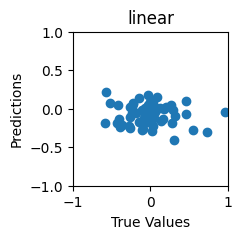

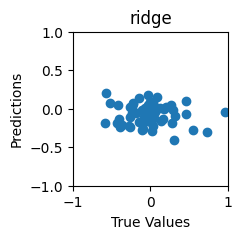

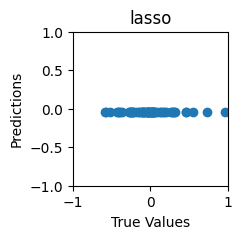

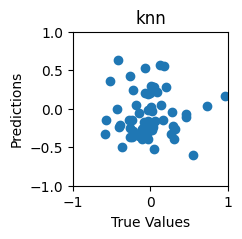

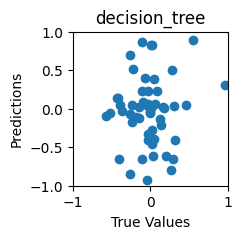

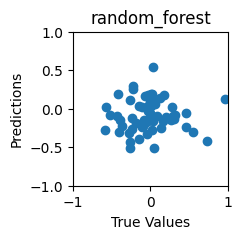

In [12]:
# Define a function to evaluate the models
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman = spearmanr(y_test, y_pred)
    
    # Plot y_test and y_pred
    fig = plt.figure(figsize=(2, 2))
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(name)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    
    return mse, r2, spearman

# Evaluate models
for name, model in models.items():
    mse, r2, spearman = evaluate_model(name, model, X_test, y_test)
    print(f"{name} model:\nMSE: {mse}\nR2: {r2}\nSpearman correlation: {spearman[0]}\n")

plt.show()

A ce stade, nous avons évalué la performance de chaque modèle et nous devons maintenant optimiser les hyperparam


# 3.6 Optimisation des hyperparamètres

L'optimisation des hyperparamètres est une étape importante pour améliorer les performances des modèles. Nous utiliserons la technique de la recherche en grille (GridSearch) pour trouver les meilleurs paramètres pour chaque modèle.

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
# Define the parameters for grid search
params = {
"linear": {},
"ridge": {"alpha": [1e-3, 1e-2, 1e-1, 1, 10, 100]},
"lasso": {"alpha": [1e-3, 1e-2, 1e-1, 1, 10, 100]},
"knn": {"n_neighbors": range(1, 11)},
"decision_tree": {"max_depth": range(1, 4), "min_samples_split": range(2, 4)},
"random_forest": {"n_estimators": [100], "max_depth": range(1, 5), "min_samples_split": range(2, 4)},
}

In [15]:
# Run grid search
for name in models:
    grid = GridSearchCV(models[name], params[name], cv=5)
    grid.fit(X_train, y_train)
    models[name] = grid.best_estimator_
    print(f"Model {name} optimized.")
print('fin')

Model linear optimized.
Model ridge optimized.
Model lasso optimized.
Model knn optimized.
Model decision_tree optimized.
Model random_forest optimized.
fin


# 3.7 Évaluation des modèles après optimisation

Une fois les hyperparamètres optimisés, nous évaluons à nouveau les modèles pour voir si leurs performances se sont améliorées.

linear model after optimization:
MSE: 0.38575611972032864
R2: -0.05088306739389781
Spearman correlation: 0.012740523826414251

ridge model after optimization:
MSE: 0.37126625275073893
R2: -0.011409537179596585
Spearman correlation: 0.055179798733612326

lasso model after optimization:
MSE: 0.37769977064354343
R2: -0.02893583079283979
Spearman correlation: 0.03638588708572853

knn model after optimization:
MSE: 0.43313412921195316
R2: -0.17995100798203967
Spearman correlation: -0.04770594084573295

decision_tree model after optimization:
MSE: 0.3681363822683723
R2: -0.0028830933335737274
Spearman correlation: nan

random_forest model after optimization:
MSE: 0.3682797558117005
R2: -0.0032736738617713534
Spearman correlation: 0.11913321930582359



C:\Users\coren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


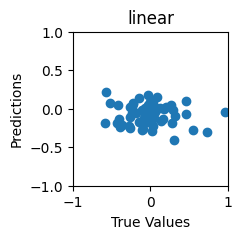

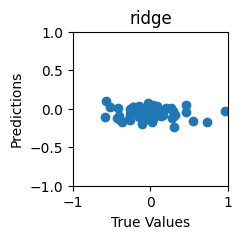

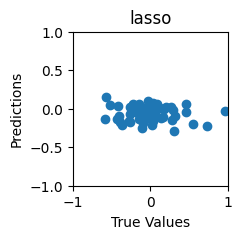

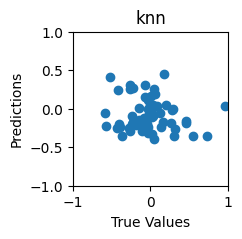

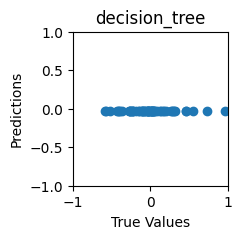

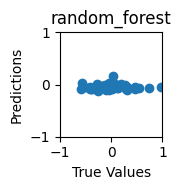

In [16]:
# Evaluate models after optimization
for name, model in models.items():
    mse, r2, spearman = evaluate_model(name, model, X_test, y_test)
    print(f"{name} model after optimization:\nMSE: {mse}\nR2: {r2}\nSpearman correlation: {spearman[0]}\n")
plt.tight_layout()
plt.show()

# 3.8 Importance des variables

Pour le modèle ayant obtenu les meilleurs résultats, nous allons évaluer l'importance des variables. Cette étape est utile pour comprendre quelles caractéristiques ont le plus contribué aux prédictions du modèle.

In [17]:
# Assume that the best model is the random forest
feature_importances = models["random_forest"].feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({"feature": feature_names, "importance": feature_importances}).sort_values("importance", ascending=False)
print(importance_df)

      feature  importance
5      FR_GAS        0.34
4     FR_WIND        0.30
0     FR_COAL        0.16
2    FR_HYDRO        0.13
3    FR_SOLAR        0.04
1  FR_NUCLEAR        0.03


Cette sortie vous donnera un aperçu de l'importance de chaque caractéristique pour le modèle de forêt aléatoire. Les variables les plus importantes seront en haut de la liste.

---
---
---

In [18]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = data_x.merge(data_y, on='ID')
df = df[ df['COUNTRY'] == 'FR' ].drop(columns=['DAY_ID', 'COUNTRY'])
df.fillna(df.mean(), inplace=True)

from scipy import stats

# Calculate Z-score for each numerical column in the dataframe
z_scores = stats.zscore(df.select_dtypes(include=np.number))

# Calculate absolute Z-score for each value in the dataframe
abs_z_scores = np.abs(z_scores)

# Remove rows with absolute Z-score greater than 3, indicating they are outliers
df = df[(abs_z_scores < 3).all(axis=1)]

# Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df.drop('TARGET', axis=1), df['TARGET'], test_size=0.2, random_state=42)

# Normaliser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entraîner un modèle LASSO avec validation croisée
lasso = LassoCV(cv=2, max_iter=10000)
lasso.fit(X_train, y_train)

# Obtenir les coefficients de chaque variable
coefficients = lasso.coef_

# Trier les coefficients par ordre décroissant en valeur absolue
sorted_coefficients = sorted(enumerate(coefficients), key=lambda x: -abs(x[1]))

# Afficher les variables les plus pertinentes
for index, coef in sorted_coefficients:
    if coef != 0:
        print(df.columns[index], coef)


FR_WINDPOW -0.0564118362402012
CARBON_RET 0.025479013184778344
GAS_RET 0.020243039668000486
DE_LIGNITE -0.011665218684867263


FR_WINDPOW -0.0564118362402012
CARBON_RET 0.02547901318477833
GAS_RET 0.020243039668000475
DE_LIGNITE -0.01166521868486728

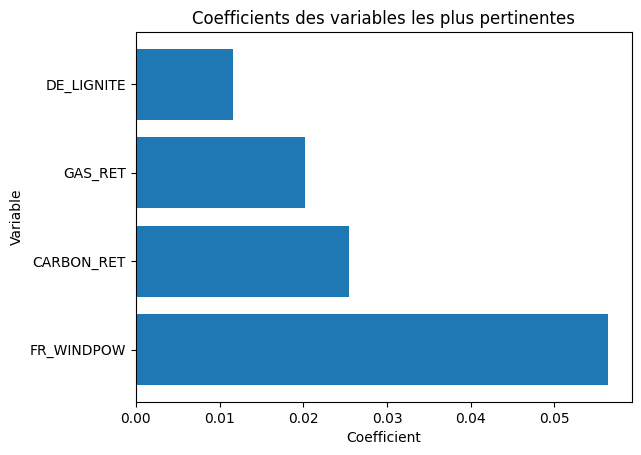

In [19]:
import matplotlib.pyplot as plt

# Créer une liste des noms de variables triés par ordre décroissant des coefficients
var_names = [df.columns[index] for index, coef in sorted_coefficients if coef != 0]

# Créer une liste des coefficients triés par ordre décroissant en valeur absolue
coeff_values = [abs(coef) for index, coef in sorted_coefficients if coef != 0]

# Créer un graphique à barres
plt.barh(var_names, coeff_values)
plt.title('Coefficients des variables les plus pertinentes')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()


---

## Verification et Traitement des valeurs manquantes

In [20]:
all_data_x.isna().sum().sum()

1402

Nous avons 1402 variables manquantes.
<br>

Analysons le nombre des valeurs manquantes par enregistrements et par variables.

### Verification des enregisterments

On compte le nombre de valeurs manquantes par enregistrements :

In [21]:
na_values_per_row = all_data_x.isna().sum(axis=1)

In [22]:
na_values_per_row.max()

6

Au maximum, il peut manquer 6 valeurs pour un enregsitrement sur 35 variables (**17%** d'information perdue au maximum pour un enregistrement).

### Verification des variables

Il y a 1402 valuers manquantes

On compte le nombre de valeurs manquantes par variable :

In [23]:
na_values_per_col = all_data_x.isna().sum()
na_values_per_col [ na_values_per_col != 0 ]

DE_FR_EXCHANGE     34
FR_DE_EXCHANGE     34
DE_NET_EXPORT     171
FR_NET_EXPORT      94
DE_NET_IMPORT     171
FR_NET_IMPORT      94
DE_RAIN           134
FR_RAIN           134
DE_WIND           134
FR_WIND           134
DE_TEMP           134
FR_TEMP           134
dtype: int64

Les variables **d'échanges** (`X_EXCHANGE`), **d'import/export** (`X_EXPORT` / `X_IMPORT`) et **metéorologiques** (`X_RAIN`, `X_WIND` et `X_TEMP`) pour les deux pays possédent des valeurs manquantes.

Au maximum, une variable peut manquer a **8%** des enregistrements (171/2148).

### Traitement des valeurs manquantes

La proportion de valeurs manquantes en lignes ou en colonnes etant relativement faible. Ces valeurs manquantes ne rendent pas inutiles ni les enregistrements ni les variables en question.<br>

Nous pouvons utiliser la médiane ou la moyenne pour remplacer les valeurs manquantes.
<br>

Nous avons choisi d'imputer les valeurs manquantes par la médiane plus robuste face au données aberrantes.

On obtient les noms des colonnes numériques :

In [24]:
numeric_columns = all_data_x.select_dtypes(include=['float64', 'int64']).columns

On calcule la mediane des colonnes numériques :

In [25]:
median_values = all_data_x[numeric_columns].median()

On remplace les valeurs manquantes par la médiane :

In [26]:
all_data_x[numeric_columns] = all_data_x[numeric_columns].fillna(median_values)

In [27]:
all_data_x.isna().sum().sum()

0

Fusion des ensembles de données
---

On souhaite obtenir un dataframe pandas contenant `data_x`, `data_y` et `dataNew_x`.

Puis on obtient le dataset de toutes les données `all_data_xy` (enregistrements et variations journalières) a l'aide de la méthode *merge()* de pandas:

In [28]:
all_data_xy = pd.merge(all_data_x, data_y, how='left', on='ID')

<br>

**`all_data_xy`** contient maintenant une colonne `TARGET` de valeur :  
- non nulle pour les enregistrements venant de `data_x` où l'on connait la variation du prix de futures d'électricité
- `Nan` pour les enregistrements venant de `dataNew_x` où l'on ne connait pas la variation du prix de futures d'électricité

---
# Analyse exploratoire des donnees

## Analyse de la variable cible

In [29]:
data_xy = all_data_xy[all_data_xy['TARGET'].notnull()]

In [30]:
tmp_fr_data_xy = data_xy[ data_xy['COUNTRY'] == 'FR']
tmp_de_data_xy = data_xy[ data_xy['COUNTRY'] == 'DE']

In [31]:
tmp_fr = tmp_fr_data_xy.sort_values(by='DAY_ID').drop_duplicates(subset='DAY_ID', keep='first')
tmp_de = tmp_de_data_xy.sort_values(by='DAY_ID').drop_duplicates(subset='DAY_ID', keep='first')

C:\Users\coren\AppData\Local\Temp\ipykernel_15664\829653693.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


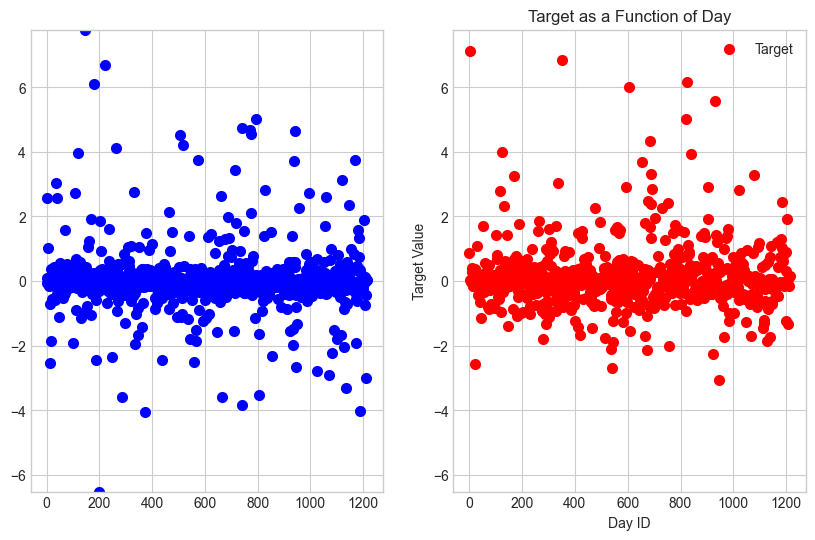

In [32]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(ncols=2, figsize=(10, 6))

axs[0].scatter(tmp_fr['DAY_ID'], tmp_fr['TARGET'], color='blue', linewidth=2, label='Target')
axs[1].scatter(tmp_de['DAY_ID'], tmp_de['TARGET'], color='red', linewidth=2, label='Target')

y_min = min(min(tmp_fr['TARGET']), min(tmp_de['TARGET']))
y_max = max(max(tmp_fr['TARGET']), max(tmp_de['TARGET']))
for ax in axs:
    ax.set_ylim(y_min, y_max)

plt.title('Target as a Function of Day')
plt.xlabel('Day ID')
plt.ylabel('Target Value')
plt.legend()

plt.show()

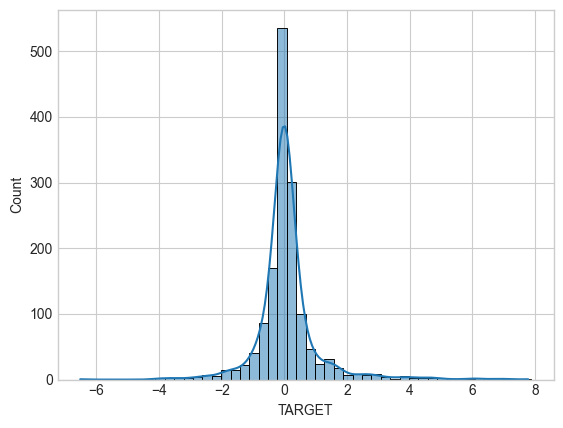

In [33]:
sns.histplot(data_xy['TARGET'], kde=True, binwidth=0.3)
plt.show()

## Pearson

Le coefficient de corrélation de Pearson mesure la relation linéaire entre deux variables quantitatives. Il varie de -1 à 1, où -1 indique une corrélation négative parfaite, 0 indique l'absence de corrélation et 1 indique une corrélation positive parfaite. Une corrélation proche de -1 ou 1 indique une forte relation linéaire entre les variables, tandis qu'une corrélation proche de 0 indique une faible relation linéaire.

$$r_{XY} = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$$


$$r_{xy} = \frac{\sum_{i=1}^{n}(x_i - \overline{x})(y_i - \overline{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \overline{x})^2}\sqrt{\sum_{i=1}^{n}(y_i - \overline{y})^2}}$$

où $r_{xy}$ est le coefficient de corrélation entre les variables $x$ et $y$, $n$ est la taille de l'échantillon, $\overline{x}$ et $\overline{y}$ sont les moyennes de $x$ et $y$, respectivement, et $x_i$ et $y_i$ sont les $i$-èmes observations de $x$ et $y$, respectivement.

### France vs Allemagne

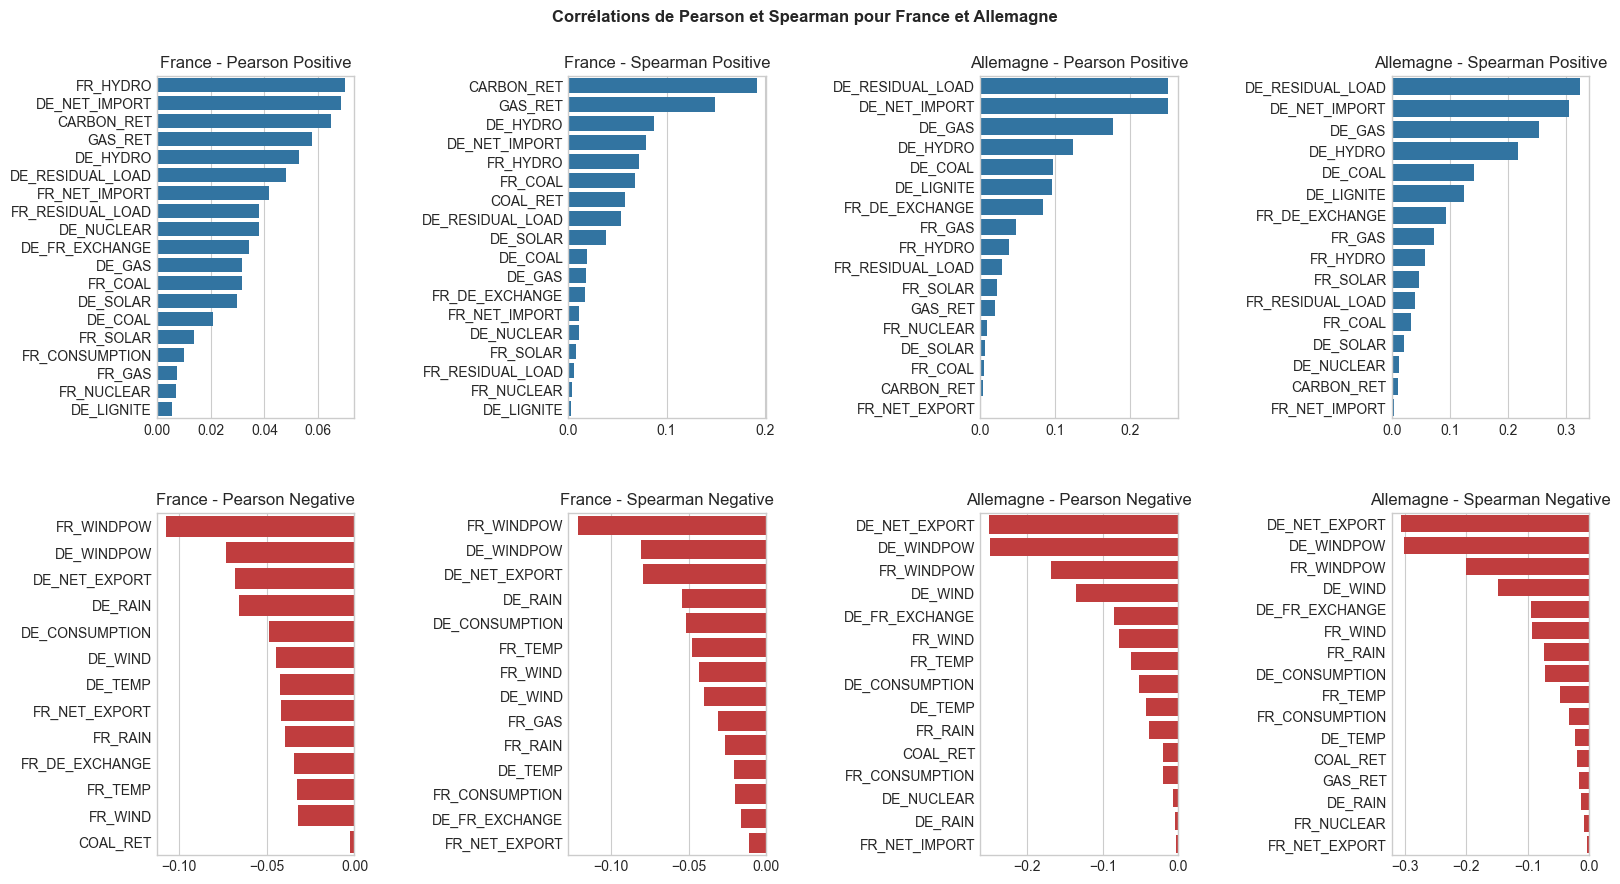

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_corr(data_xy, country, method):
    data = data_xy[data_xy['COUNTRY'] == country].copy()
    data_x = data.drop(columns=['DAY_ID', 'COUNTRY', 'TARGET'])
    corr_matrix = data_x.corrwith(data['TARGET'], method=method)
    corr_matrix.sort_values(ascending=False)
    corr_positive = corr_matrix[corr_matrix > 0].sort_values(ascending=False)
    corr_negative = corr_matrix[corr_matrix <= 0].sort_values()
    
    return corr_positive, corr_negative

def plot_corr(corr_positive, corr_negative, country, method, ax1, ax2):
    sns.barplot(x=corr_positive.values, y=corr_positive.index, ax=ax1, color='tab:blue')
    ax1.set_title(f"{country} - {method.capitalize()} Positive")
    sns.barplot(x=corr_negative.values, y=corr_negative.index, ax=ax2, color='tab:red')
    ax2.set_title(f"{country} - {method.capitalize()} Negative")

fr_corr_positive, fr_corr_negative = calculate_corr(data_xy, 'FR', 'pearson')
de_corr_positive, de_corr_negative = calculate_corr(data_xy, 'DE', 'pearson')
fr_spearman_corr_positive, fr_spearman_corr_negative = calculate_corr(data_xy, 'FR', 'spearman')
de_spearman_corr_positive, de_spearman_corr_negative = calculate_corr(data_xy, 'DE', 'spearman')

fig, axs = plt.subplots(2, 4, figsize=(17,10))

plot_corr(fr_corr_positive, fr_corr_negative, "France", 'Pearson', axs[0, 0], axs[1, 0])
plot_corr(fr_spearman_corr_positive, fr_spearman_corr_negative, "France", 'Spearman', axs[0, 1], axs[1, 1])

plot_corr(de_corr_positive, de_corr_negative, "Allemagne", 'Pearson', axs[0, 2], axs[1, 2])
plot_corr(de_spearman_corr_positive, de_spearman_corr_negative, "Allemagne", 'Spearman', axs[0, 3], axs[1, 3])

plt.suptitle("Corrélations de Pearson et Spearman pour France et Allemagne", fontweight='bold', y=0.92)
plt.tight_layout(pad=4)
plt.show()


In [35]:
def calculate_corr(data_xy, country, method):
    data = data_xy[data_xy['COUNTRY'] == country].copy()
    data_x = data.drop(columns=['DAY_ID', 'COUNTRY', 'TARGET'])
    corr_matrix = data_x.corrwith(data['TARGET'], method=method)
    corr_matrix.sort_values(ascending=False)
    corr_positive = corr_matrix[corr_matrix > 0].sort_values(ascending=False)
    corr_negative = corr_matrix[corr_matrix <= 0].sort_values()
    
    return corr_positive, corr_negative

def plot_corr(corr_positive, corr_negative, country, method):
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))
    sns.barplot(x=corr_positive.values, y=corr_positive.index, ax=axs[0], color='tab:blue')
    axs[0].set_title(country)
    sns.barplot(x=corr_negative.values, y=corr_negative.index, ax=axs[1], color='tab:red')
    axs[1].set_title(country)
    plt.suptitle(f"Corrélations de {method.capitalize()} positives et négatives pour " + country, fontweight='bold')
    plt.tight_layout(w_pad=6, h_pad=10)
    plt.show()

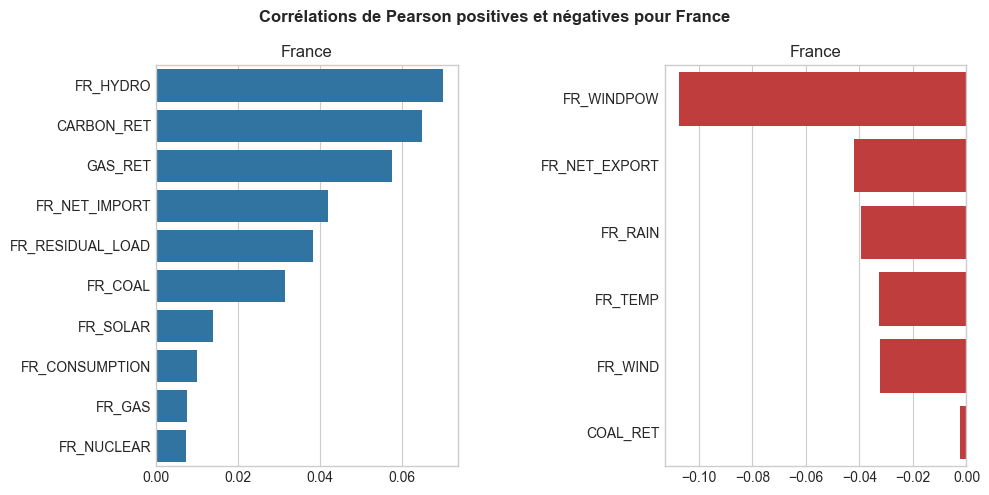

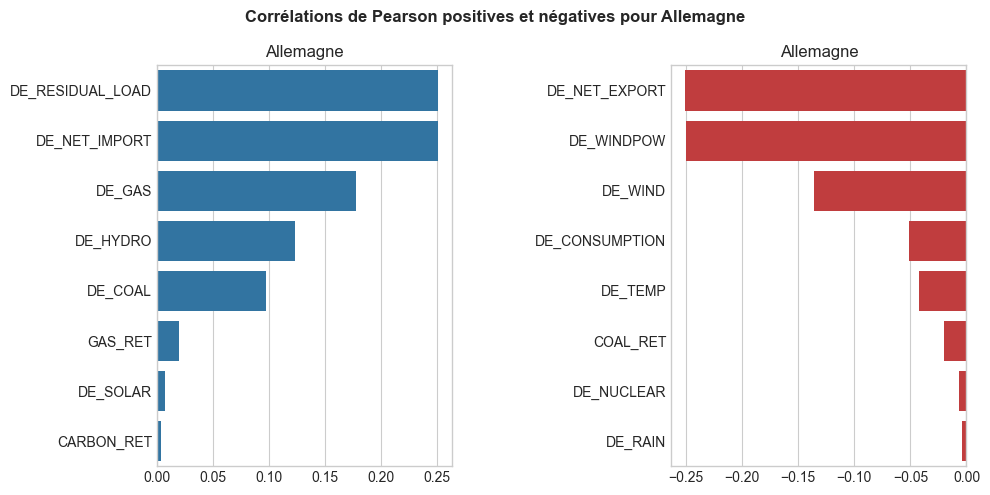

In [36]:
# fr_corr_positive, fr_corr_negative = calculate_corr(data_xy, 'FR', 'pearson')
# de_corr_positive, de_corr_negative = calculate_corr(data_xy, 'DE', 'pearson')

fr_corr_positive, fr_corr_negative = calculate_corr(data_xy[vars_fr + ['COUNTRY', 'DAY_ID', 'TARGET', 'GAS_RET', 'COAL_RET', 'CARBON_RET']], 'FR', 'pearson')
de_corr_positive, de_corr_negative = calculate_corr(data_xy[vars_de + ['COUNTRY', 'DAY_ID', 'TARGET', 'GAS_RET', 'COAL_RET', 'CARBON_RET']], 'DE', 'pearson')

plot_corr(fr_corr_positive, fr_corr_negative, "France", 'pearson')
plot_corr(de_corr_positive, de_corr_negative, "Allemagne", 'pearson')

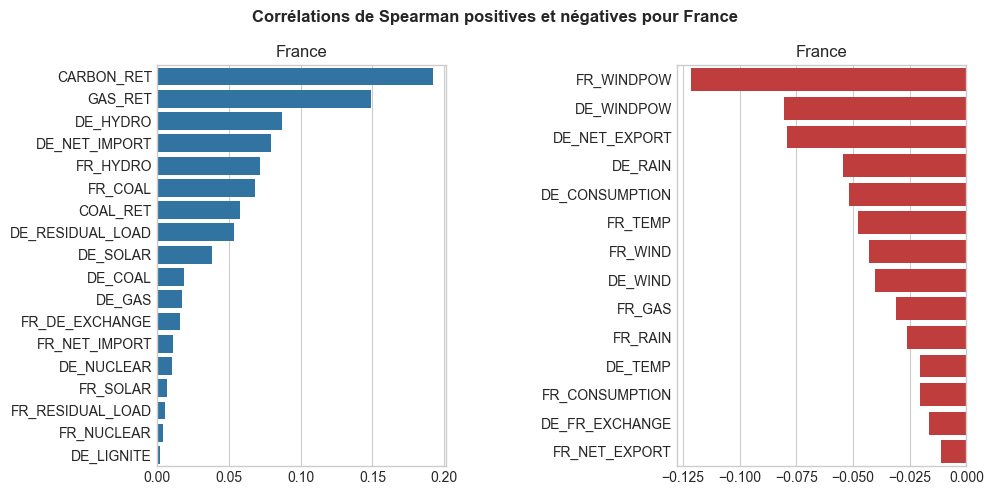

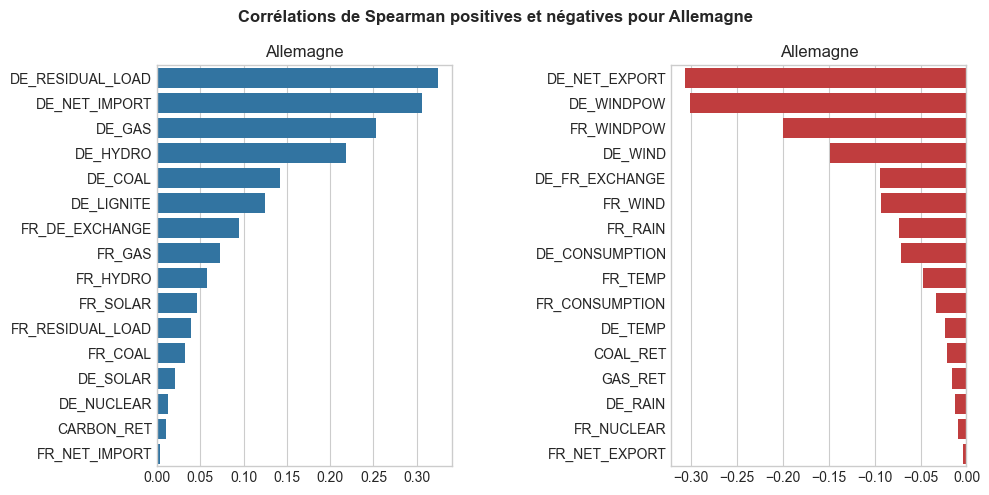

In [37]:
fr_corr_positive, fr_corr_negative = calculate_corr(data_xy, 'FR', 'spearman')
de_corr_positive, de_corr_negative = calculate_corr(data_xy, 'DE', 'spearman')

plot_corr(fr_corr_positive, fr_corr_negative, "France", 'spearman')
plot_corr(de_corr_positive, de_corr_negative, "Allemagne", 'spearman')

---

# Test PCA

In [38]:
import pandas as pd
from sklearn.linear_model import Ridge

df = data_xy.drop(columns=['DAY_ID', 'COUNTRY'])

# séparation des données en features (X) et target (y)
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# entraînement du modèle de régression Ridge
model = Ridge(alpha=0.1)
model.fit(X, y)

# calcul des coefficients de régression
coefficients = list(zip(X.columns, model.coef_))

# tri des variables par ordre décroissant de coefficient
coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

# affichage des résultats
for col, coef in coefficients:
    print(col, coef)

FR_RESIDUAL_LOAD -0.4135984330409855
FR_CONSUMPTION 0.24047244897491277
FR_NUCLEAR 0.2351699239024318
DE_NET_EXPORT -0.14813908171932436
DE_NET_IMPORT 0.14813908171927967
FR_WINDPOW -0.1326837374480159
FR_SOLAR -0.08990645097920869
DE_FR_EXCHANGE 0.08971948925246921
FR_DE_EXCHANGE -0.0897194892520877
DE_CONSUMPTION -0.08459019178567942
FR_WIND 0.08407516514688715
DE_RESIDUAL_LOAD 0.060906632563054654
FR_GAS 0.05828634948745248
FR_NET_EXPORT -0.05657816922461593
FR_NET_IMPORT 0.056578169224524695
FR_HYDRO 0.052993832362922336
DE_HYDRO 0.0492178400409025
DE_WIND -0.04920522102380359
DE_LIGNITE -0.0472913519836444
DE_GAS -0.04728739738173525
DE_COAL -0.04287021519757965
DE_SOLAR -0.03238174301093138
FR_COAL -0.026064154131906842
GAS_RET 0.024960603130013102
DE_WINDPOW 0.02287753039873331
FR_RAIN -0.021680606197550537
DE_TEMP -0.019975403306556908
COAL_RET -0.016881401569817423
DE_RAIN -0.016093606308831453
CARBON_RET 0.01292480614157123
DE_NUCLEAR -0.008671971916862078
FR_TEMP 0.000805624

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# création d'un dataframe avec les coefficients
df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

# tri des features par ordre décroissant de coefficient
df = df.sort_values('Coefficient', ascending=False)

# création du graphique à barres
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=df, color='blue')

# ajout de labels
plt.title('Coefficients de régression Ridge')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
# plt.show()
df


,Feature,Coefficient
1,FR_CONSUMPTION,0.240472
2,FR_NUCLEAR,0.235170
4,DE_NET_IMPORT,0.148139
7,DE_FR_EXCHANGE,0.089719
10,FR_WIND,0.084075
11,DE_RESIDUAL_LOAD,0.060907
12,FR_GAS,0.058286
14,FR_NET_IMPORT,0.056578
15,FR_HYDRO,0.052994
16,DE_HYDRO,0.049218


In [40]:
df = data_xy.drop(columns=['DAY_ID', 'COUNTRY'])

In [41]:
df.isna().sum().sum()

0

In [42]:
from sklearn.linear_model import LogisticRegression


# Séparation des données en variables explicatives et variable cible
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Entraînement d'un modèle de régression logistique
model = LogisticRegression().fit(X, y)

# Extraction des coefficients du modèle
coef_values = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)



ValueError: Unknown label type: 'continuous'

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = data_xy.drop(columns=['DAY_ID', 'COUNTRY'])
# Normalisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Création de l'objet PCA
pca = PCA()

# Ajustement de l'objet PCA aux données normalisées
pca.fit(df_scaled)

# Calcul des pourcentages de variance expliquée par chaque composante principale
variance_ratio = pca.explained_variance_ratio_

# Affichage des pourcentages de variance expliquée pour chaque composante principale
print("Variance expliquée par chaque composante principale :")
print(variance_ratio)

# Projection des données sur les deux premières composantes principales
pca_df = pca.transform(df_scaled)[:, :2]

# Calcul des charges factorielles pour les deux premières composantes principales
loadings = pca.components_[:2,:].T * np.sqrt(pca.explained_variance_[:2])

# Récupération des noms de colonnes des variables initiales
feature_names = df.columns.tolist()

# Création d'un DataFrame pour afficher les charges factorielles
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=feature_names)

# Affichage des charges factorielles triées par ordre décroissant pour PC1
print('Charges factorielles pour PC1:')
print(loadings_df['PC1'].abs().sort_values(ascending=False))

# Affichage des charges factorielles triées par ordre décroissant pour PC2
print('Charges factorielles pour PC2:')
print(loadings_df['PC2'].abs().sort_values(ascending=False))

# Affichage des variables les plus importantes pour expliquer 'TARGET'
target_loadings = loadings_df.loc[:, 'PC1':'PC2'][['TARGET']]
target_loadings_abs = target_loadings.abs().sort_values(by='TARGET', ascending=False)
print('Variables les plus importantes pour expliquer TARGET:')
print(target_loadings_abs)


### Calcul du coefficient de correlation de Spearman 

In [ ]:
from scipy.stats import shapiro, spearmanr

grouped_xy_by_DAY = data_xy.groupby(by='DAY_ID')

# Créer des listes pour stocker les valeurs de fr_target et de_target
fr_targets = []
de_targets = []

for name, group in grouped_xy_by_DAY:
    # Vérifier s'il y a au moins un 'COUNTRY' = 'FR' ou 'DE'
    if 'FR' in group['COUNTRY'].values and 'DE' in group['COUNTRY'].values:
        # Vérifier si tous les 'TARGET' sont identiques
        if len(set(group['TARGET'])) > 1:
            fr_target = group.loc[group['COUNTRY'] == 'FR', 'TARGET'].values[0]
            de_target = group.loc[group['COUNTRY'] == 'DE', 'TARGET'].values[0]
            
            # Ajouter les valeurs de fr_target et de_target aux listes
            fr_targets.append(fr_target)
            de_targets.append(de_target)

# Test de normalité sur les données de fr_target et de_target
_, fr_pvalue = shapiro(fr_targets)
_, de_pvalue = shapiro(de_targets)

alpha = 0.05
if fr_pvalue < alpha or de_pvalue < alpha:
    print("\nLes données ne suivent pas une distribution normale.")
    # Utiliser le coefficient de corrélation de Spearman
    correlation, _ = spearmanr(fr_targets, de_targets)
    print(f"\nCoefficient de corrélation de Spearman: {correlation:.2f}")
else:
    print("\nLes données suivent une distribution normale.")
    # Utiliser le coefficient de corrélation de Pearson
    correlation, _ = pearsonr(fr_targets, de_targets)
    print(f"\nCoefficient de corrélation de Pearson: {correlation:.2f}")


---

## Visualisation des données

Nous créons des graphiques (histogrammes, boîtes à moustaches, séries chronologiques) pour visualiser la distribution et la tendance des variations journalières des futures d'électricité pour chaque pays.

In [ ]:
fr_series = data_xy[data_xy['COUNTRY'] == 'FR']['TARGET'].reset_index(drop=True)
de_series = data_xy[data_xy['COUNTRY'] == 'DE']['TARGET'].reset_index(drop=True)
fr_series.shape
fr_series.sample()

In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
# sns.histplot(fr_data, kde=True, ax=axes[0, 0])
# axes[0, 0].set_title("Histogramme des variations journalières (France)")

In [ ]:
# sns.histplot(de_data, kde=True, ax=axes[0, 1])
# axes[0, 1].set_title("Histogramme des variations journalières (Allemagne)")

In [ ]:
# sns.boxplot(x='COUNTRY', y='TARGET', data=data_xy, ax=axes[1, 0])
# axes[1, 0].set_title("Boîtes à moustaches des variations journalières")

In [ ]:
# ax1 = axes[1, 1].twinx()
# fr_series.plot(ax=axes[1, 1], color='b', label='France')
# de_series.plot(ax=ax1, color='r', label='Allemagne')
# axes[1, 1].set_title("Séries chronologiques des variations journalières")
# axes[1, 1].legend(loc='upper left')
# ax1.legend(loc='upper right')

# plt.tight_layout()
# plt.plot()

## Test d'indépendance

Nous effectuons des tests statistiques de Kolmogorov-Smirnov et d'Anderson-Darling pour vérifier si les distributions des variations journalières des futures d'électricité pour les deux pays sont indépendantes.

In [ ]:
# # Test d'indépendance
# ks_stat, ks_pvalue = ks_2samp(fr_data, de_data)
# print("Test de Kolmogorov-Smirnov:")
# print("Statistique :", ks_stat)
# print("p-valeur :", ks_pvalue)

# anderson_stat, anderson_critic, anderson_signif = anderson_ksamp([fr_data, de_data])
# print("\nTest d'Anderson-Darling:")
# print("Statistique :", anderson_stat)
# print("Valeurs critiques :", anderson_critic)
# print("Niveaux de signification :", anderson_signif)


Dans les deux cas, les résultats sont très significatifs (p < 0.001), ce qui suggère que les distributions des variations journalières des futures d'électricité pour la France et l'Allemagne sont indépendantes. Ainsi, il serait approprié d'utiliser deux modèles distincts pour chaque pays.

## Test de différence de moyenne

Nous effectuons des tests statistiques t de Student et de Mann-Whitney pour vérifier s'il existe une différence significative entre les moyennes des variations journalières des futures d'électricité pour les deux pays.


In [ ]:
# from scipy.stats import ttest_ind
# from scipy.stats import mannwhitneyu


# # Test de différence de moyenne
# t_stat, t_pvalue = ttest_ind(fr_data, de_data)
# print("\nTest t de Student:")
# print("Statistique :", t_stat)
# print("p-valeur :", t_pvalue)

# mw_stat, mw_pvalue = mannwhitneyu(fr_data, de_data)
# print("\nTest de Mann-Whitney:")
# print("Statistique :", mw_stat)
# print("p-valeur :", mw_pvalue)


### Conclusion

Nous avons analysé les données des variations journalières des futures d'électricité pour la France et l'Allemagne en effectuant une analyse exploratoire des données et en réalisant des tests statistiques pour vérifier l'indépendance des distributions et les différences de moyenne entre les deux pays.

Si les p-valeurs des tests statistiques sont inférieures au seuil de signification (par exemple, 0,05), nous pouvons rejeter l'hypothèse nulle et conclure que les distributions des variations journalières des futures d'électricité pour les deux pays sont indépendantes et/ou que les moyennes des variations sont significativement différentes. Dans ce cas, cela renforce l'argument pour utiliser des modèles distincts pour chaque pays.


# Analyse exploratoire des données

In [ ]:
# to remove
tmp_data_x = data_x.drop(columns=['DAY_ID', 'COUNTRY'])

## Analyse univariée

### France

In [ ]:
all_fr_data_x = all_data_x[all_data_x['COUNTRY'] == 'FR'].drop(columns=['DAY_ID', 'COUNTRY'])
all_fr_data_x.shape

In [ ]:
from univariate_analysis import plot_group_hist_boxplot, var_groups

df = all_fr_data_x
        
for group_title, group_vars in var_groups.items():
    display_m(f"### {group_title} de la France")
    plot_group_hist_boxplot(group_vars, df)

### Allemagne

In [ ]:
all_de_data_x = all_data_x[all_data_x['COUNTRY'] == 'DE'].drop(columns=['DAY_ID', 'COUNTRY'])
all_de_data_x.shape

In [ ]:
from univariate_analysis import plot_group_hist_boxplot, var_groups

df = all_de_data_x
        
for group_title, group_vars in var_groups.items():
    display_m(f"### {group_title} de la France")
    plot_group_hist_boxplot(group_vars, df)

<hr style="border:2px solid gray" />

## Analyse multivariée
----------------------

In [ ]:
df = pd.merge(data_x, data_y, on='ID')
plt.figure(figsize=(10, 8))
plt.title('Matrice de corrélation')
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

## Analyse bivaries avec la target

In [ ]:
df = pd.merge(data_x, data_y, on='ID')
plt.figure(figsize=(10, 8))
target_variable = 'TARGET'
corr_matrix = df.corr()
corr_with_target = corr_matrix[target_variable].sort_values(ascending=False)
sorted_corr_matrix = corr_matrix.loc[corr_with_target.index, corr_with_target.index]
sns.heatmap(sorted_corr_matrix, cmap='coolwarm')
plt.title('Matrice de corrélation avec la variable cible')
plt.show()

In [ ]:
import pandas as pd
from bivariate_analysis import get_variable_strength_list, create_corr_markdown_table

data_x = pd.read_csv("data/Data_X.csv", index_col='ID')
data_y = pd.read_csv("data/Data_Y.csv", index_col='ID')

df = pd.merge(data_x, data_y, on='ID')

corr_matrix = df.corr()

# On appelle les fonctions pour récupérer la liste de variables avec leur force de corrélation et créer le tableau Markdown
var_strength_list = get_variable_strength_list(corr_matrix)
table_str = create_corr_markdown_table(var_strength_list[1:]) # On ignore la corrélation TARGET-TARGET
# On affiche le tableau Markdown
display(Markdown(table_str))